In [3]:
import pylab as pl
import pandas as pd
import numpy as np
import scipy.stats

%pylab inline

import os
import json
s = json.load( open(os.getenv ('PUIDATA')+"/fbb_matplotlibrc.json") )
pl.rcParams.update(s)

Populating the interactive namespace from numpy and matplotlib


In [4]:
def getCitiBikeCSV(datestring):
    print ("Downloading", datestring)
    ### First I will heck that it is not already there
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        if os.path.isfile(datestring + "-citibike-tripdata.csv"):
            # if in the current dir just move it
            if os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA")):
                print ("Error moving file!, Please check!")
        #otherwise start looking for the zip file
        else:
            if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip"):
                if not os.path.isfile(datestring + "-citibike-tripdata.zip"):
                    os.system("curl -O https://s3.amazonaws.com/tripdata/" + datestring + "-citibike-tripdata.zip")
                ###  To move it I use the os.system() functions to run bash commands with arguments
                os.system("mv " + datestring + "-citibike-tripdata.zip " + os.getenv("PUIDATA"))
            ### unzip the csv 
            os.system("unzip " + os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip")
            ## NOTE: old csv citibike data had a different name structure. 
            if '2014' in datestring:
                os.system("mv " + datestring[:4] + '-' +  datestring[4:] + 
                          "\ -\ Citi\ Bike\ trip\ data.csv " + datestring + "-citibike-tripdata.csv")
            os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA"))
    ### One final check:
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        print ("WARNING!!! something is wrong: the file is not there!")

    else:
        print ("file in place, you can continue")

In [5]:
datestring = '201501'
getCitiBikeCSV(datestring)

('Downloading', '201501')
file in place, you can continue


In [6]:
df = pd.read_csv(os.getenv("PUIDATA") + "/" + datestring + '-citibike-tripdata.csv')
df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,1346,1/1/2015 0:01,1/1/2015 0:24,455,1 Ave & E 44 St,40.750020,-73.969053,265,Stanton St & Chrystie St,40.722293,-73.991475,18660,Subscriber,1960.0,2
1,363,1/1/2015 0:02,1/1/2015 0:08,434,9 Ave & W 18 St,40.743174,-74.003664,482,W 15 St & 7 Ave,40.739355,-73.999318,16085,Subscriber,1963.0,1
2,346,1/1/2015 0:04,1/1/2015 0:10,491,E 24 St & Park Ave S,40.740964,-73.986022,505,6 Ave & W 33 St,40.749013,-73.988484,20845,Subscriber,1974.0,1
3,182,1/1/2015 0:04,1/1/2015 0:07,384,Fulton St & Waverly Ave,40.683178,-73.965964,399,Lafayette Ave & St James Pl,40.688515,-73.964763,19610,Subscriber,1969.0,1
4,969,1/1/2015 0:05,1/1/2015 0:21,474,5 Ave & E 29 St,40.745168,-73.986831,432,E 7 St & Avenue A,40.726218,-73.983799,20197,Subscriber,1977.0,1


In [7]:
df.columns

Index([u'tripduration', u'starttime', u'stoptime', u'start station id',
       u'start station name', u'start station latitude',
       u'start station longitude', u'end station id', u'end station name',
       u'end station latitude', u'end station longitude', u'bikeid',
       u'usertype', u'birth year', u'gender'],
      dtype='object')

In [8]:
df.drop(['starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude','usertype', 'bikeid','gender'], axis=1, inplace=True)

In [9]:
df['age'] = 2015 - df['birth year']

In [10]:
df.head()

,tripduration,birth year,age
0,1346,1960.0,55.0
1,363,1963.0,52.0
2,346,1974.0,41.0
3,182,1969.0,46.0
4,969,1977.0,38.0


In [11]:
# dropping NaN values
df['age'].dropna(inplace= True)
df['tripduration'].dropna(inplace= True)
df['birth year'].dropna(inplace= True)
len(df)

285552

In [14]:
# remove trip duration = 0
df = df.drop(df[df.tripduration == 0].index)

In [15]:
# remove age older than 90
df = df.drop(df[df.age > 90].index)

In [55]:
TripMean = df.tripduration.sum()/len(df)
print (TripMean)

654


In [58]:
df['MeanTrip'] = TripMean

In [59]:
df.head()

,tripduration,birth year,age,MeanTrip
0,1346,1960.0,55.0,654
1,363,1963.0,52.0,654
2,346,1974.0,41.0,654
3,182,1969.0,46.0,654
4,969,1977.0,38.0,654


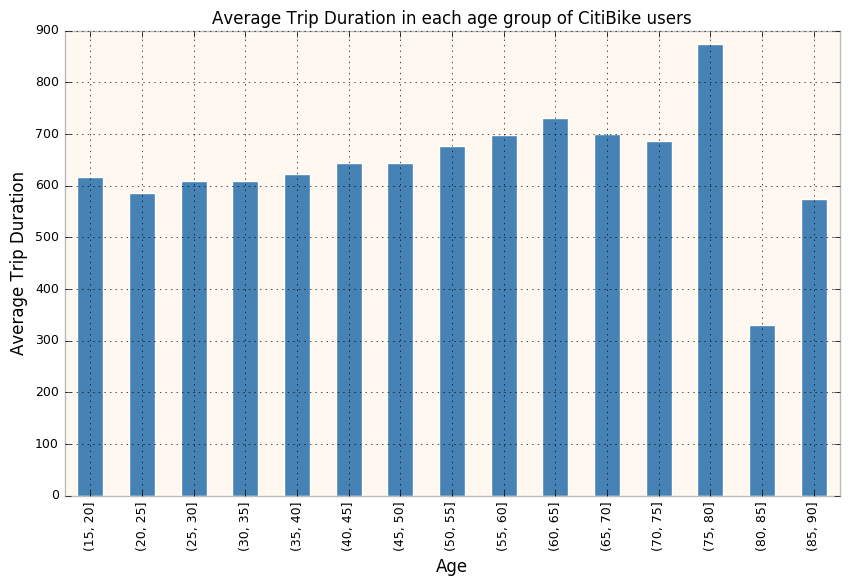

In [70]:
fig = pl.figure(figsize(10,6))
bins = np.arange(15, 91, 5)
ax = df.tripduration.groupby(pd.cut(df.age, bins)).mean().plot(kind='bar', legend=False, fontsize=9)
ax.set_ylabel ("Average Trip Duration", fontsize=12)
ax.set_xlabel ("Age", fontsize=12)
ax.set_title("Average Trip Duration in each age group of CitiBike users", fontsize=12)
plt.savefig('HW7_plot_zn352.png')

### Figure 1: This figure displays the average trip duration time in seconds for CitiBike users in age groups 15 to 90 years old. We do not see significant differences between each group, although in (75,80] age group the average time spend riding CitiBike is much higher, while in (80,85] age group a dip. It would be interesting to investigate what the pead and dip corresponds to: we can speculate sample data might be not representative enough in those categories, or that elder CitiBike riders (supposingly above 75 years old) have less steady consumer behavior routine than younger riders. 